# **Parsing the Show Floor Map**
I want a "Map Page", where users can see the location of a booth on the PAX map. In order to do that, I'll need to identify the bounding boxes of each booth within the image. 

# Setup
The cells below will help to set up the rest of the notebook. 

I'll start by configuring the kernel that's running this notebook:

In [ ]:
# Change the cwd
%cd ..

# Enable the autoreload module
%load_ext autoreload
%autoreload 2

# Load the environment variables
from dotenv import load_dotenv
load_dotenv(override=True)

Next, I'm going to import the necessary modules:

In [2]:
# General imports
import json, re

# Third-party imports
from google.cloud import vision

# Section
Description

In [19]:
service_account_json = (
    "/Users/thubbard/Documents/login-credentials/pax-pal-2025-0cde56c6edfe.json"
)

IMG = "data/pax-map.jpg"
# Use the service account JSON file for authentication
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    service_account_json
)
client = vision.ImageAnnotatorClient(credentials=credentials)

with open(IMG, "rb") as f:
    response = client.text_detection(image=vision.Image(content=f.read()))

digits = {}
for anno in response.text_annotations[1:]:  # skip the full‑page blob
    text = anno.description.strip()
    if not re.fullmatch(r"\d+", text):
        continue

    # bounding_poly has 4 vertices (x,y). Flatten to [x1,y1,x2,y2].
    xs = [v.x for v in anno.bounding_poly.vertices]
    ys = [v.y for v in anno.bounding_poly.vertices]
    bbox = [min(xs), min(ys), max(xs), max(ys)]

    # Group multi‑chunk numbers (15 + 043 → 15043)
    y_mid = (bbox[1] + bbox[3]) // 2
    key = f"{y_mid:05d}"  # line key
    digits.setdefault(key, []).append((bbox, text))

# merge adjacent chunks on the same scan‑line
booths = {}
for line in digits.values():
    line.sort(key=lambda t: t[0][0])  # sort left→right
    cur_box, cur_txt = line[0]
    for box, txt in line[1:]:
        if box[0] - cur_box[2] < 15:  # ≤ 15 px gap?
            # extend right edge & concat text
            cur_box[2] = box[2]
            cur_txt += txt
        else:
            booths[cur_txt] = cur_box
            cur_box, cur_txt = box, txt
    booths[cur_txt] = cur_box

with open("data/booths.json", "w") as f:
    json.dump(booths, f, indent=2)
print(f"Saved {len(booths)} booths 🗺️")

# Create a DataFrame of the proposed_booths
import pandas as pd

booths_df = pd.DataFrame(booths.items(), columns=["booth", "bbox"])

Saved 284 booths 🗺️


Below, we'll make a method that highlights a parituclar booth's bounding box on the map. 

/var/folders/p0/6dyp2b_d72z_d772nvm0y6tc0000gn/T/ipykernel_52217/2163117739.py:97: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


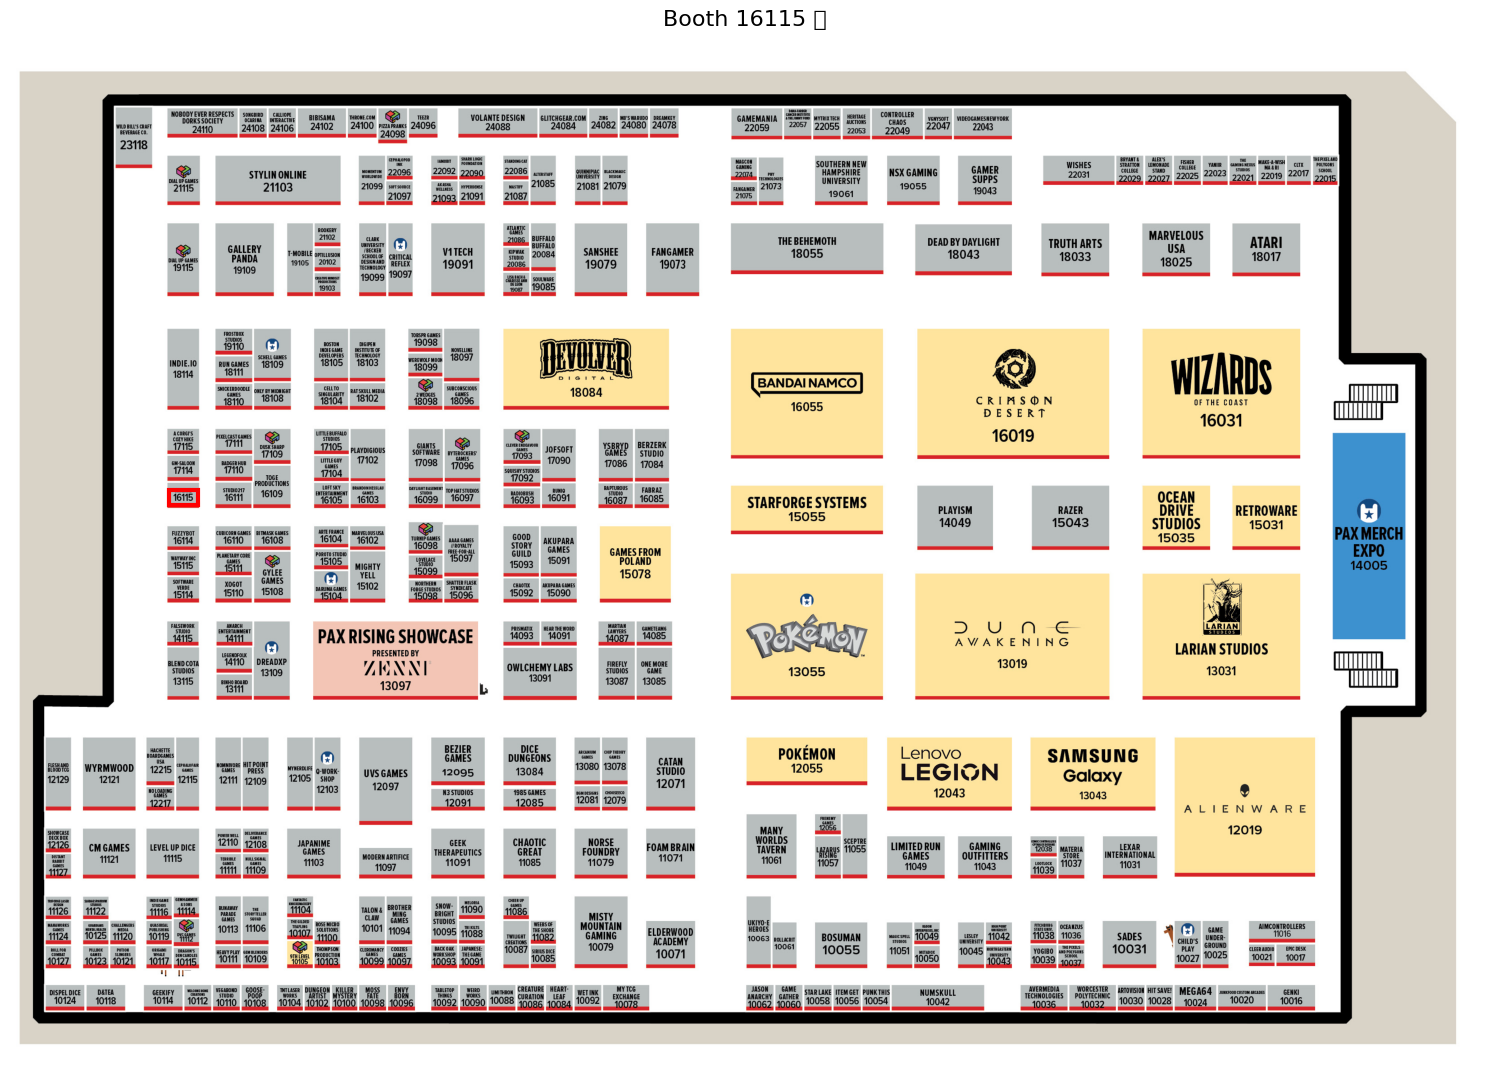

Found 1 booth(s):
  - Booth 16115: x=362-407, y=1022-1037


In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


def highlight_booths(
    booth_ids=None,
    booths_df=booths_df,
    img_path=IMG,
    padding=10,
    figsize=(15, 15),
    highlight_all=False,
):
    """
    Displays the map with highlighted booths.

    Args:
        booth_ids (list, str, optional): The ID(s) of the booth(s) to highlight. Can be a single string or a list.
        booths_df (DataFrame): DataFrame containing booth information
        img_path (str): Path to the map image
        padding (int): Extra padding around the booth for visibility
        figsize (tuple): Size of the figure to display
        highlight_all (bool): If True, highlights all booths in the dataframe

    Returns:
        None: Displays the image with highlighted booth(s)
    """
    # Convert single booth_id to list for consistent processing
    if booth_ids is not None and isinstance(booth_ids, str):
        booth_ids = [booth_ids]

    # If highlight_all is True, use all booth IDs
    if highlight_all:
        booth_ids = booths_df["booth"].tolist()

    # If no booth_ids provided and not highlighting all, show error
    if not booth_ids and not highlight_all:
        print(
            "No booth IDs provided! Please specify booth_ids or set highlight_all=True 😕"
        )
        return

    # Load the image
    img = Image.open(img_path)
    img_array = np.array(img)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Display the image
    ax.imshow(img_array)

    # Track booths found and not found
    found_booths = []
    not_found_booths = []

    # Add rectangles for each booth
    for booth_id in booth_ids:
        # Find the booth in our dataframe
        booth_row = booths_df[booths_df["booth"] == booth_id]

        if booth_row.empty:
            not_found_booths.append(booth_id)
            continue

        # Get the bounding box
        bbox = booth_row.iloc[0]["bbox"]
        x1, y1, x2, y2 = bbox
        found_booths.append((booth_id, x1, y1, x2, y2))

        # Create a rectangle patch with padding
        rect = patches.Rectangle(
            (x1 - padding, y1 - padding),
            (x2 - x1) + 2 * padding,
            (y2 - y1) + 2 * padding,
            linewidth=3,
            edgecolor="r",
            facecolor="none",
        )

        # Add the rectangle to the plot
        ax.add_patch(rect)

    # Set title based on mode
    if highlight_all:
        ax.set_title(f"All {len(found_booths)} Booths 🎮", fontsize=16)
    elif len(booth_ids) == 1:
        ax.set_title(f"Booth {booth_ids[0]} 🎮", fontsize=16)
    else:
        ax.set_title(f"Selected Booths ({len(found_booths)} found) 🎮", fontsize=16)

    # Remove axes
    ax.axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print results
    if not_found_booths:
        print(f"Booths not found: {', '.join(not_found_booths)} 😕")

    if found_booths:
        print(f"Found {len(found_booths)} booth(s):")
        for booth_id, x1, y1, x2, y2 in found_booths:
            print(f"  - Booth {booth_id}: x={x1}-{x2}, y={y1}-{y2}")


# Example usage:
highlight_booths("16115")  # Single booth
# highlight_booths(["TT01", "23118", "24110"])  # Multiple booths
# highlight_booths(highlight_all=True)  # All booths